# Diagrama de Voronoi utilizando librería de Python

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import pandas as pd
%matplotlib inline

In [21]:
# Semilla de los datos aleatorios
np.random.seed(2022)
points = np.random.uniform(size=[22, 2])

<Figure size 720x720 with 0 Axes>

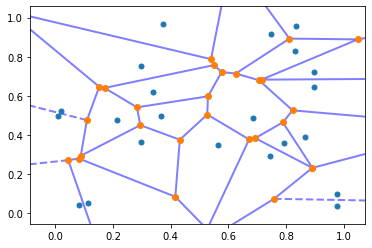

In [29]:
# Diagrama de Voronoi, puntos generados en azul, los vértices de Voronoi en naranja
vor = Voronoi(points)
vor.vertices.shape
fig = plt.figure(figsize=(10, 10))
fig = voronoi_plot_2d(vor, show_vertices=True, line_colors='blue',
                line_width=2, line_alpha=0.5, point_size=10)
plt.show()
fig.savefig('voronoi_simple.png',dpi=fig.dpi)

### Se coloroean las regiones de Voronoi por una variable cuantitativa

<Figure size 720x720 with 0 Axes>

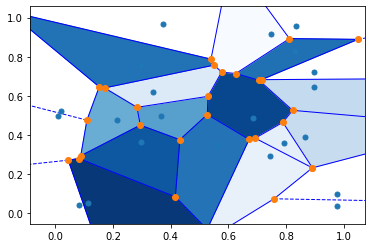

In [49]:
# Generar puntos y variable cuantitativa para mapear color
v_cuant = np.random.uniform(low=0.0, high=10.0, size=22)

# Generar el conjunto de Voronoi
vor = Voronoi(points)

# Mínimo y Máximo de la variable cuantitativa
minimo = min(v_cuant)
maximo = max(v_cuant)

# Normalización del color
norm = mpl.colors.Normalize(vmin=minimo, vmax=maximo, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues_r)

# Diagrama de Voronoi, rellena las regiones finistas con el color mapeado
fig = plt.figure(figsize=(10, 10))
fig=voronoi_plot_2d(vor, show_points=True, line_colors='blue',show_vertices=True, point_size=10)
for r in range(len(vor.point_region)):
    region = vor.regions[vor.point_region[r]]
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), color=mapper.to_rgba(v_cuant[r]))   
plt.show()
fig.savefig('voronoi_coloured.png',dpi=fig.dpi)


### Las líneas discontinuas...

Las líneas discontinuas indican que los vértices son infinitos (y fuera del área mostrada), con lo que la celda de Voronoi es infinita.

La librería scipy.spatial no proporciona ningún método directo para generar diagramas finitos de Voronoi, aunque en Github se puede encontrar el método **voronoi_finite_polygons_2d** en https://gist.github.com/pv/8036995. El método desarrollado por Pauli Virtanen calcula los vértices infinitos y los "cierra" para tener regiones finitas y poder pintarlas. Utilizo su código para ver cómo quedaría el gráfico anterior.

22


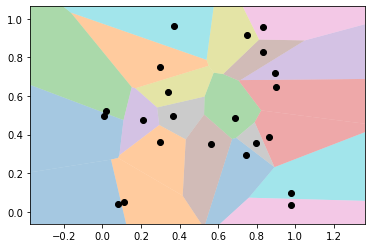

In [64]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# make up data points
#np.random.seed(1234)
#points = np.random.rand(15, 2)

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
print(len(regions))
# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:,0], points[:,1], 'ko')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.savefig('voronoi_finite_pv.png')
plt.show()